In [1]:
# Imports
import os
from glob import glob
import random

from collections import OrderedDict
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from skimage import img_as_ubyte

from skimage.io import imread, imsave


In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
### Read in data paths

DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"
image_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_files.append(i.replace('_mask',''))

# Train test split
df = pd.DataFrame(data={"images": image_files, 'masks' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


In [4]:
pwd

'/kaggle/working'

In [5]:
""" 

Class for MRI dataset.

In original code, images are cropped, padded, resized, and normalized.

Images are also augmented by scaling, rotating, and horizontally flipping.

"""

class MRITrainDataset(Dataset):
    
    # Takes in a dataframe of (image, mask) and a pytorch transform
    def __init__(self, df, transform_params):
        self.image_list = list(df.images)
        self.mask_list = list(df.masks)
        self.transform_params = transform_params
    
    def __len__(self):
        return(len(self.image_list))
    
    def __getitem__(self, i):

        # Read in image
        image = cv.imread(self.image_list[i])
        mask = cv.imread(self.mask_list[i], cv.IMREAD_GRAYSCALE)
        
        # Apply transform or convert image ndarray to tensor
        if self.transform_params is not None:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
            image, mask = self.transform(image, mask)

        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        
        return image, mask
    
    def transform(self, img, mask):
        
        (cropsize, padding, imsize, degrees, scale, pflip, mean, stdev) = self.transform_params  
        
        # Convert to PIL image
        img = transforms.ToPILImage()(img)
        mask = transforms.ToPILImage()(mask)
        
        # Crop boundry by cropsize pixels
#         img = transforms.CenterCrop(cropsize)(img)
#         mask = transforms.CenterCrop(cropsize)(mask)
        
        # Pad boundary by padding pixels
        img = transforms.Pad(padding)(img)
        mask = transforms.Pad(padding)(mask)
        
        # Resize image?
        img = transforms.Resize(imsize)(img)
        mask = transforms.Resize(imsize)(mask)
        
        # Affine transform = rotation + scaling, ignoring translation
        angle = np.random.uniform(low=degrees[0], high=degrees[1])
        scale = np.random.uniform(low=scale[0], high=scale[1])    
        img = TF.affine(img, angle=angle, scale=scale, translate=(0, 0), shear=0)
        mask = TF.affine(mask, angle=angle, scale=scale, translate=(0, 0), shear=0)
        
        # Horizontal flip
        if np.random.uniform(0, 1) < pflip:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
            
        # Convert to tensor
        img = transforms.ToTensor()(img)
        mask = transforms.ToTensor()(mask)
            
        # Normalize img only
        img = transforms.Normalize(mean, stdev)(img)
        
        return img, mask
  


In [6]:
""" 

Class for MRI dataset for validation and testing.

Just normalizes images.

"""

class MRITestDataset(Dataset):
    
    # Takes in a dataframe of (image, mask) and a pytorch transform
    def __init__(self, df, transform_params):
        self.image_list = list(df.images)
        self.mask_list = list(df.masks)
        self.transform_params = transform_params
    
    def __len__(self):
        return(len(self.image_list))
    
    def __getitem__(self, i):

        # Read in image
        image = cv.imread(self.image_list[i])
        mask = cv.imread(self.mask_list[i], cv.IMREAD_GRAYSCALE)
        
        # Apply transform or convert image ndarray to tensor
        if self.transform_params is not None:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
            image, mask = self.transform(image, mask)

        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        
        return image, mask
    
    def transform(self, img, mask):
        
        (mean, stdev) = self.transform_params  
            
        # Normalize img only
        img = transforms.Normalize(mean, stdev)(img)
        
        return img, mask
  


In [7]:
# Calculate mean and stdev of rgb values for training set
"""
mean_pixels = np.zeros(3)
std_pixels = np.zeros(3)
for fn in df_train.images:
    
    img = cv.imread(fn)
    
    mean_pixels += np.mean(img, axis=(0, 1))
    std_pixels += np.std(img, axis=(0, 1))


mean_pixels /= len(df_train.images)
std_pixels /= len(df_train.images)
"""


'\nmean_pixels = np.zeros(3)\nstd_pixels = np.zeros(3)\nfor fn in df_train.images:\n    \n    img = cv.imread(fn)\n    \n    mean_pixels += np.mean(img, axis=(0, 1))\n    std_pixels += np.std(img, axis=(0, 1))\n\n\nmean_pixels /= len(df_train.images)\nstd_pixels /= len(df_train.images)\n'

In [8]:
batch_size = 16

# Initialize data transformer parameters
cropsize = 224
padding = 0
imsize = 224
degrees = (0, 15)
scale = (0.95, 1.05)
pflip = 0.5
#mean = (mean_pixels[0], mean_pixels[1], mean_pixels[2])
#stdev = (std_pixels[0], std_pixels[1], std_pixels[2])

# precalculated to speed up time
mean = np.array([22.35764175, 21.24672404, 23.55368457])
stdev = np.array([29.6112217 , 28.04271793, 29.0924923 ])


transform_params = (

    cropsize,
    padding,
    imsize,
    degrees, 
    scale,
    pflip,
    mean,
    stdev

)

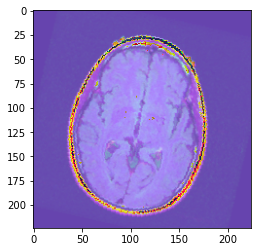

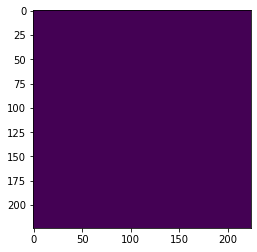

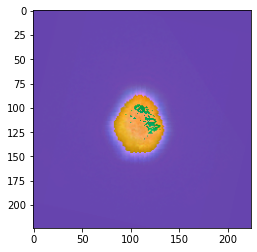

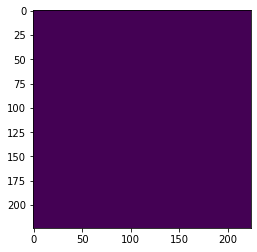

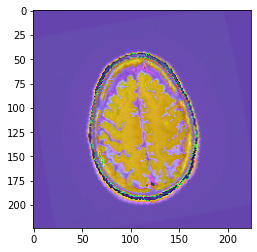

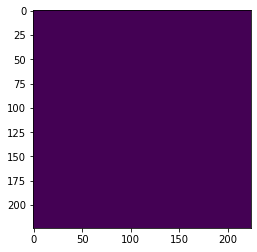

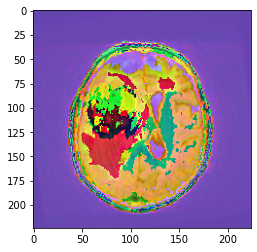

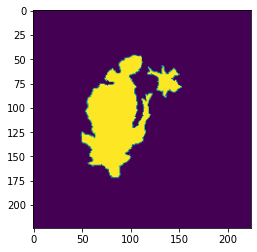

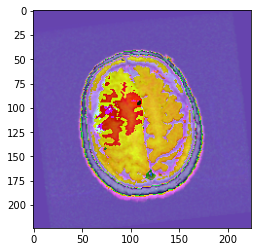

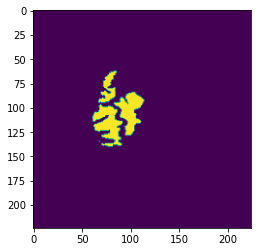

In [9]:

# Create MRI datasets and dataloaders
train_dataset = MRITrainDataset(df_train, transform_params)
val_dataset = MRITestDataset(df_val, (mean, stdev))
test_dataset = MRITestDataset(df_test, (mean, stdev))

# Show some data
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

for step, (image, mask) in enumerate(train_loader):

    
    image = torch.reshape(image, (3, imsize, imsize))
    mask = torch.reshape(mask, (imsize, imsize))
    
    imx = transforms.ToPILImage()(image * 50)
    mkx = transforms.ToPILImage()(mask)
    plt.figure()
    plt.imshow(imx)
    plt.figure()
    plt.imshow(mkx)

    if step == 4:
        break

# Reset to proper training batchsize
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
# Taken from other code, computes dice loss
"""
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc
"""

# Also copied from somewhere else
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [11]:
def train(model, train_loader, val_loader, epochs, lr, mean, stdev):
    
    # Can try different optimizers
    optimizer = torch.optim.Adam(model.parameters(), lr)
    compute_loss = DiceLoss()
    
    train_loss, train_loss_epoch, val_loss = [], [], []
    
    if torch.cuda.is_available():
        model = model.cuda()
    else:
        print("ERROR: CUDA NOT AVAILABLE")
        return [], []
    
    for epoch in range(epochs):
        
        # Train
        for step, (image, mask) in enumerate(train_loader):
            
            optimizer.zero_grad()
            
            image = image.cuda()
            mask = mask.cuda()
                
            mask_hat = model(image)
            loss = compute_loss(mask_hat, mask)
            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
            del image, mask, mask_hat
            
        # Validate
        vl = []
        for step, (image, mask) in enumerate(val_loader):
            
            image = image.cuda()
            mask = mask.cuda() 
                
            mask_hat = model(image)
            loss = compute_loss(mask_hat, mask)
            vl.append(loss.item())
            
            del image, mask, mask_hat
            
        val_loss.append(np.mean(vl))
        train_loss_epoch.append(np.mean(train_loss[-len(train_loader):]))
        
        print("Epoch: {0}".format(epoch + 1))
        print("Train Loss: {0}".format(train_loss_epoch[-1]))
        print("Validation Loss: {0}".format(val_loss[-1]))
     
    return train_loss, val_loss
            

In [12]:
def test(model, test_loader, mean, stdev):
    
    compute_loss = DiceLoss()
    test_loss = []
    
    if torch.cuda.is_available():
        model = model.cuda()
    else:
        print("ERROR: CUDA NOT AVAILABLE")
        return []
    
    for step, (image, mask) in enumerate(test_loader):
            
        image = image.cuda()
        mask = mask.cuda()
        
        mask_hat = model(image)
        loss = compute_loss(mask_hat, mask)
        test_loss.append(loss.item())
        
        del image, mask, mask_hat
        
    return test_loss  
        
        

In [13]:
class UNet(nn.Module):
    # Taken from https://www.kaggle.com/mateuszbuda/brain-segmentation-pytorch
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [14]:
def plot_results(train_loss,val_loss,val_dsc):
    # Plot validation DSC and loss on a single plot
    plt.rcParams.update({'font.size': 10})
    fig, (ax1,ax3) = plt.subplots(2,1)
    x_val = np.arange(len(val_loss))
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Val. Loss')
    ax1.plot(x_val,np.array(val_loss), color=color, marker='o')
    ax1.tick_params(axis='y')
#     ax2 = ax1.twinx() 
#     color = 'tab:blue'
#     ax2.set_ylabel('Val. DSC', color=color)
#     ax2.plot(x_val,val_dsc, color=color, marker='o')
#     ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("U-Net Training Session")
    ax1.grid(True)

    # Plot training losses in another subplot
    x = np.linspace(0,len(val_loss)-1,len(train_loss))
    color = 'tab:red'
    batch_plot, = ax3.plot(x,train_loss, color=color, label="Batch Loss")
    train_loss_epoch = [np.mean(train_loss[epoch_idx*len(train_loader):(epoch_idx+1)*len(train_loader)-1]) for epoch_idx in range(epochs)]
    epoch_plot, = ax3.plot(x_val,train_loss_epoch,marker='o',label="Epoch Loss")
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Train Loss')
    ax3.grid(True)
    plt.legend(handles=[batch_plot,epoch_plot])

    fig.tight_layout()
    plt.savefig("training_plot.png",dpi=500)
    plt.show()
    
def plot_segmentations(image,seg_true,seg_hat):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3)
    ax1.imshow(image)
    ax1.set_title("MRI Image")
    ax2.imshow(seg_true)
    ax2.set_title("Truth Mask")
    ax3.imshow(seg_hat)
    ax3.set_title("Predicted Mask")
    fig.tight_layout()
    plt.savefig("seg_plot.png",dpi=500)
    plt.show()

In [15]:
model = UNet()

# Params taken from other code
epochs = 30
lr = 0.0001
#train_loss, val_loss = train(model, train_loader, val_loader, epochs, lr, mean, stdev)

#plot_results(train_loss,val_loss,val_loss)


In [16]:
#plot_results(train_loss,val_loss,val_loss)

In [17]:
model.load_state_dict(torch.load("/kaggle/input/unet-weights/weights.pth"))

<All keys matched successfully>

In [18]:
model.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    test_loss = test(model, test_loader, mean, stdev)
test_loss

[0.13884270191192627,
 0.9196274876594543,
 0.9203332662582397,
 0.9189001321792603,
 0.9222211837768555,
 0.0999222993850708,
 0.9189723134040833,
 0.9179322719573975,
 0.9114898443222046,
 0.916214108467102,
 0.5214102864265442,
 0.9901476502418518,
 0.21155458688735962,
 0.052612364292144775,
 0.9147077798843384,
 0.5088987350463867,
 0.9174248576164246,
 0.9180915951728821,
 0.9196074604988098,
 0.9989755153656006,
 0.9175928831100464,
 0.9213716983795166,
 0.12162882089614868,
 0.9227491021156311,
 0.926059365272522,
 0.9200790524482727,
 0.9790976047515869,
 0.9150727987289429,
 0.9185109734535217,
 0.9160813689231873,
 0.03298342227935791,
 0.9211962223052979,
 0.13464969396591187,
 0.9194513559341431,
 0.059313952922821045,
 0.9205983281135559,
 0.9203036427497864,
 0.9149554371833801,
 0.04906529188156128,
 0.12706148624420166,
 0.9171105027198792,
 0.9168241024017334,
 0.9200068712234497,
 0.9200572371482849,
 0.9987930655479431,
 0.9142744541168213,
 0.9208784699440002,
 0.9

In [41]:
test_losses = np.array(test_loss)
mean_test_loss = np.mean(test_losses[test_losses<0.9]) # remove the blanks
test_mean_dice = 1-mean_test_loss
test_mean_dice

0.8421427916203226

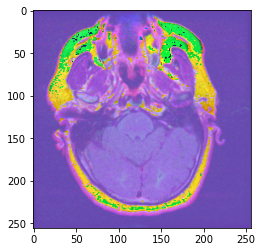

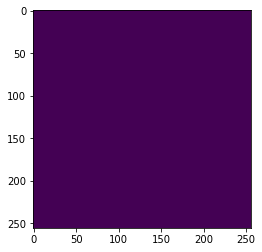

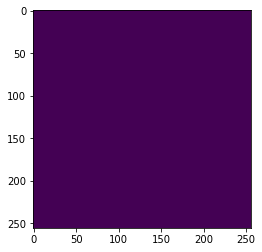

In [28]:
image,mask = test_dataset.__getitem__(1)
mask_hat = model(image.unsqueeze(0).cuda())
image = torch.reshape(image, (3, 256, 256))
mask = torch.reshape(mask, (256, 256))
mask_hat = torch.reshape(mask_hat.cpu(), (256, 256))

imx = transforms.ToPILImage()(image * 50)
mkx = transforms.ToPILImage()(mask)
mkhx = transforms.ToPILImage()(mask_hat)
plt.figure()
plt.imshow(imx)
plt.figure()
plt.imshow(mkx)
plt.figure()
plt.imshow(mkhx)

tensor(11.4421, grad_fn=<SumBackward0>)

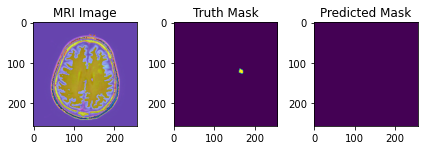

In [20]:
plot_segmentations(imx,mkx,mkhx)

In [21]:
#torch.save(model.state_dict(), "weights.pth")

In [22]:
# Compute masks for all slices in dataset and save them off in identical file structure 

dataset_path = "../input/lgg-mri-segmentation/kaggle_3m"
patient_dirs = glob(dataset_path+'/*/')

for patient_dir in patient_dirs:
    # make the patient directory in the new folder
    new_patient_dir = "kaggle_3m-automasks" + patient_dir.replace(dataset_path,'')
    if not os.path.exists(new_patient_dir):
        os.makedirs(new_patient_dir)
    # get a list of the image filenames
    volume_names = glob(patient_dir+'*[0-9].tif')
    # load the slices for this patient
    volumes = [transforms.Normalize(mean, stdev)(transforms.ToTensor()(cv.imread(volume_name))) for volume_name in volume_names]
    batch = torch.stack(volumes)
    batch = batch.to('cuda')
    
    with torch.no_grad():
        mask_hats = model(batch)

    mask_hats = mask_hats.cpu().detach().numpy()

    for i in range(len(volume_names)):
        mask_hat_path = new_patient_dir + os.path.basename(volume_names[i])
        mask_hat_path = mask_hat_path.replace(".tif","_maskhat.tif")
        imsave(mask_hat_path,img_as_ubyte(np.squeeze(mask_hats[i,:,:,:])),check_contrast=False)
    
# loop through patient folders in dataset

# create an equivalent folder in the target directory
# get all the images and load them into a tensor as a batch
# do the necessary pre-processing (just normalization i think)
# put them through the network to produce a batch of masks
# save each mask off as an image in the new directory

KeyboardInterrupt: 

In [ ]:
mask_hat_path